# Inference with Memento10k models

In [3]:
# Imports
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import sys

from keras_models import build_model_multigpu
from captioning_utils import *
from vid_utils import *
from generator import preprocess_rgb_fast


# Load model

In [4]:
# MODEL
embedding_matrix = get_embedding_matrix('vocab_embedding_3.json',
                                        'vocab_3.json')

model = build_model_multigpu(type='rgb', 
                           model_type='i3d_cap_sentence_early',
                           image_size=224,
                           num_frames=45, 
                           num_classes=2,
                           gpus=1,
                           use_pretrained=True, 
                           verbose=True, 
                           download_weights=True,
                           downsample_factor=None, 
                           dropout_prob=0.3, 
                           final_activation='tanh', 
                           show_internal_summary=False,
                           rescale=1,
                           embedding_matrix=embedding_matrix,
                           output_biases=None)

# CHECKPOINT
W = 'memento10k_rgb_fzn0_resc1_LTmse_a1b100c1000_w1_gpus1_bs12_do0.30_ep25_valloss1.1338_valrc0.5957_capacc0.400.hdf5'
if W:
    model.load_weights(W)

Working with single GPU
x.shape after downsa: (None, 23, 28, 28, 192)
channels_last
x.shape after last conv: (None, 5, 1, 1, 400)
Loading downloaded weights into model: rgb_imagenet_and_kinetics from path: /home/camilo/.keras/models/i3d_inception_rgb_imagenet_and_kinetics.h5
video_out.shape (internal representation over 5 pseudo-frames) (None, 5, 1, 1, 1024)
x.shape after last conv (None, 5, 1, 1, 2)
Model: "i3d_captions"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 45, 224, 224, 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 45, 224, 224, 0           input_2[0][0]                    
_______________________________________________________________________________

# Load data

In [7]:
# Define your list of videos here
containing_folder = '../../memento'
video_names = ['bicycling/6-0-9-1-7-5-7-8-4360917578.mp4', 
          'crawling/flickr-3-9-4-5-1-5-9-0-3739451590_6.mp4',
          'drinking/flickr-1-5-9-5-9-3-1-2-21215959312_26.mp4'] 

# Load and preprocess videos
videos = load_vids_opencv(video_names, containing_folder, is_train=False)
videos = preprocess_rgb_fast(videos, is_train=False)

# Define dictionary mapping words to idxs
word2idx={}
word2idx['0']=0
for i,w in enumerate(json.load(open('vocab_3.json'))):
    word2idx[w]=i+1

# Predict and view predictions

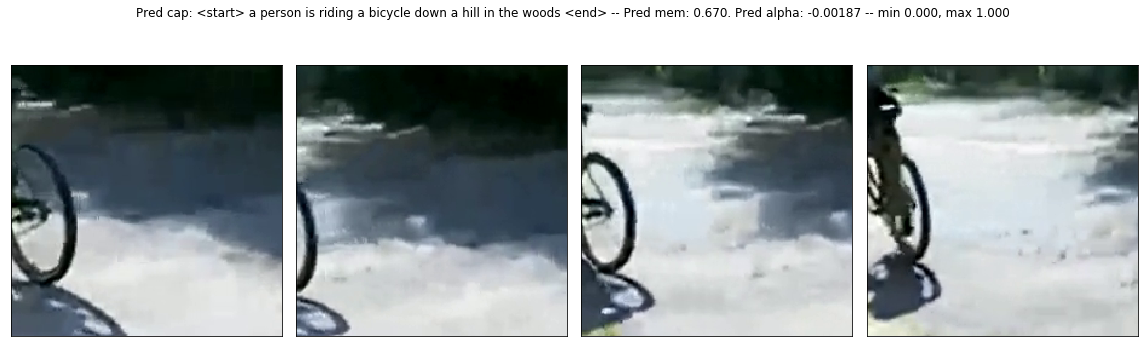

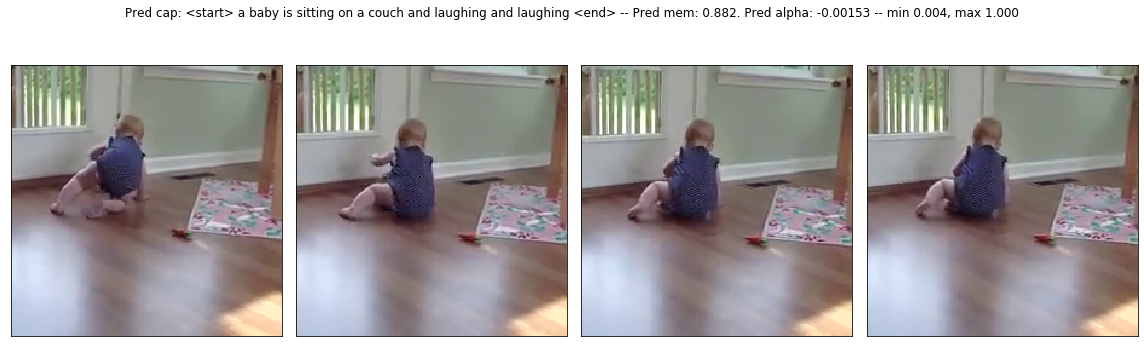

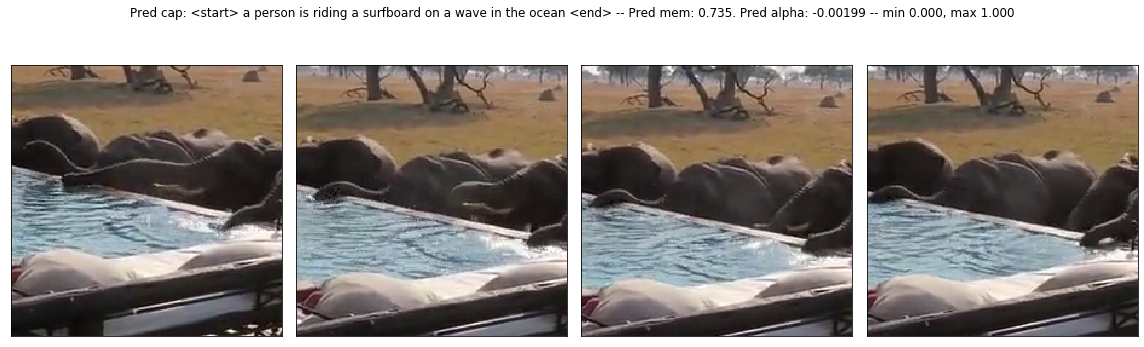

In [8]:
# Aux function to get preds
def generate_captions_sentence(model, input_video, max_cap_len=50, verbose=True, 
                               gr_truth_cap=None, return_mem_alpha=False):

    if gr_truth_cap is not None:
        input_cap = gr_truth_cap
    else:
        input_cap = np.array([word2idx['<start>']])

    for i in range(max_cap_len-1):
        mem_alpha, cap = model.predict([[input_video], [input_cap[:i+1]]])
        predicted_word = np.argmax(cap[0][i])
        if gr_truth_cap is None:
            input_cap = np.append(input_cap,predicted_word)
        if predicted_word == word2idx['<end>']:
            break
            
    if verbose: print("Final predicted caption:", " ".join(to_words(input_cap)))
    if return_mem_alpha:
        return input_cap, mem_alpha
    else:
        return input_cap

    
# View predictions
captions = []
pred_mem = []
pred_alpha = []

for i,v in enumerate(videos):
    
    # Predict memorability and caption
    cap, mem_alpha = generate_captions_sentence(model, input_video=v, return_mem_alpha=True, verbose=False)
    mem_alpha=mem_alpha[0]
    cap = " ".join(to_words(cap))
    captions.append(cap)
    pred_mem.append(mem_alpha[0])
    pred_alpha.append(mem_alpha[1])
    
    # Show input video, predicted caption and predicted mem and alpha
    plot_frames(v, 
                title='Pred cap: %s -- Pred mem: %.3f. Pred alpha: %.5f --' % (cap, mem_alpha[0], mem_alpha[1]),
                is_optical_flow=False,
                suptitle_y=0.95,
                is_255image=True,
                frames_to_show=4)
    
        

In [10]:
# Save predictions
save_dict = {}
for i,v in enumerate(video_names):
    save_dict[v] = {'mem':str(pred_mem[i]), 'alpha':str(pred_alpha[i]), 'cap':captions[i]}
    
print("save_dict:",save_dict)
json.dump(save_dict, open("./mem_alpha_caption_predictions.json", 'w+'), indent=2)

save_dict: {'bicycling/6-0-9-1-7-5-7-8-4360917578.mp4': {'mem': '0.66985023', 'alpha': '-0.0018678518', 'cap': '<start> a person is riding a bicycle down a hill in the woods <end>'}, 'crawling/flickr-3-9-4-5-1-5-9-0-3739451590_6.mp4': {'mem': '0.88171035', 'alpha': '-0.0015340371', 'cap': '<start> a baby is sitting on a couch and laughing and laughing <end>'}, 'drinking/flickr-1-5-9-5-9-3-1-2-21215959312_26.mp4': {'mem': '0.73473', 'alpha': '-0.0019895888', 'cap': '<start> a person is riding a surfboard on a wave in the ocean <end>'}}
